In [134]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# Load and Clean Data

In [2]:
building_raw = pd.read_csv('building_fire_risk.csv')
demo_raw = pd.read_csv('demographic_data/nyc_demographic_data.csv')
eco_raw = pd.read_csv('nyc_economic_data.csv')
fire_inc_all_raw = pd.read_csv('FireIncidenceAll.csv')
fire_inc_high_raw = pd.read_csv('HighRiskData.csv')
fire_inc_low_raw = pd.read_csv('LowRiskData.csv')

#### Demographic data (demo)

In [3]:
# Remove 'Total_Language_Population' column because all values are NaN and
# 'Median_Year_Built' because data is already captured in building data
demo = demo_raw.drop(['Total_Language_Population', 'Median_Year_Built'], axis=1)
demo.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,Not_in_Labor_Force,Employed,Unemployed,Median_Travel_Time,Total_With_Disability,No_Health_Insurance,Vehicles_Available,Foreign_Born,Median_Earnings,Households_with_Broadband
140,11374,43173,41.6,19991,23182,21237,1882,38,14084,0,...,23587,23576,822,19916,43162,0,19044,24481,54913,16358
81,11104,25037,38.2,11773,13264,14891,420,115,6163,0,...,15198,15198,955,12901,25037,0,11281,11137,53105,9831
94,11211,104561,30.8,53058,51503,74440,6567,350,6641,32,...,58033,58006,3093,47565,104322,24,40821,22359,63591,32162
90,11207,90867,35.5,41427,49440,12502,57897,276,1399,121,...,41388,41323,4762,33862,90278,0,34010,27803,37012,26791
33,10037,19177,38.6,8092,11085,2339,12961,81,763,8,...,9126,9112,928,6977,18935,0,9797,2888,54718,7877


#### Building data (building)

In [4]:
# Assign risks to each zipcode
# high risk: 5, medium risk: 3, low risk: 1
building = building_raw.copy()
building = building.replace({'high':3, 'medium':2, 'low':1})

# Calculate total risk per zipcode
building['total_risk'] = building['risk'] * building['count']
build_risks = building.groupby('zipcode').sum()['total_risk']
building = building.merge(build_risks, on='zipcode', how='left').drop(['risk', 'count', 'total_risk_x'], axis=1).rename({'total_risk_y':'total_risk'}, axis=1)
building.drop_duplicates(inplace=True)

# Assign area_mile2 to zipcodes without value. Use minimum area_mile2 / 2
new_area_mile2 = building_raw.area_mile2.min() / 2
building.area_mile2 = building.area_mile2.fillna(new_area_mile2)

# Calculate average risk per zipcode
building['avg_build_risk'] = building.apply(lambda x: round(x['total_risk'] / x['area_mile2'], 3), axis=1)

# Keep useful columns and rename zipcode to ZIP to be consistent with other datasets
building = building[['zipcode', 'avg_build_risk']].rename({'zipcode': 'ZIP'}, axis=1)

building.sample(5)

C:\Users\kevin\AppData\Local\Temp\ipykernel_34676\2515830439.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  building = building.replace({'high':3, 'medium':2, 'low':1})


,ZIP,avg_build_risk
39,10016,6937.258
139,10120,1438.217
276,10803,27.120
165,10301,5838.636
343,11212,12268.252


#### Economic data (eco)

In [5]:
eco = eco_raw.copy()
# Extract useful columns
eco = eco[['ZIP', 'est_households_total', 'est_households_median_income_dollars', 'est_households_mean_income_dollars', 
          'est_families_total', 'est_families_median_income_dollars', 'est_families_mean_income_dollars', 
          'est_married_couple_families_total', 'est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars',
          'est_nonfamily_households_total', 'est_nonfamily_households_median_income_dollars', 'est_nonfamily_households_mean_income_dollars']]
eco.sample(5)

,ZIP,est_households_total,est_households_median_income_dollars,est_households_mean_income_dollars,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars
150,11414,11523,98209.0,135426,7834,123873.0,165111,5665,138750.0,NaN,3689,41516,65226
44,10304,15900,71506.0,107989,10801,91624.0,128469,6302,117562.0,NaN,5099,43682,60989
8,10010,16192,156127.0,253684,6113,224893.0,354599,4728,NaN,NaN,10079,118003,191753
64,10462,29538,63460.0,80576,18182,70874.0,90744,9275,91068.0,103002.0,11356,43626,57088
94,11211,27497,105183.0,155194,12214,82826.0,139906,8742,102240.0,NaN,15283,124359,163149


#### Fire Incident Data

In [6]:
# Extract useful columns
fire_inc_all = fire_inc_all_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'all_incident'}, axis=1)
fire_inc_low = fire_inc_low_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'low_incident'}, axis=1)
fire_inc_high = fire_inc_high_raw[['MODZCTA', 'Count']].rename({'MODZCTA':'ZIP', 'Count':'high_incident'}, axis=1)

In [7]:
# Combine all data and calculate medium risk incidents
inc = fire_inc_all.merge(fire_inc_low, on='ZIP', how='left')
inc = inc.merge(fire_inc_high, on='ZIP', how='left')
inc['med_incident'] = inc['all_incident'] - inc['high_incident'] - inc['low_incident']
inc.drop('all_incident', inplace=True, axis=1)

In [8]:
# Assign risks to each zipcode
risk_factor = {'high':3, 'medium':2, 'low':1}
inc['fire_incident_risk'] = inc['high_incident'] * risk_factor['high'] \
                            + inc['med_incident'] * risk_factor['medium'] \
                            + inc['low_incident'] * risk_factor['low']
# Drop 'low_incident', 'med_incident', 'high_incident' columns
inc = inc[['ZIP', 'fire_incident_risk']]

In [9]:
# Merge with buildings_raw to include area size
inc = inc.merge(building_raw, left_on='ZIP', right_on='zipcode', how='left').drop_duplicates('ZIP')[['ZIP', 'fire_incident_risk', 'area_mile2']]

In [10]:
# Calculate average fire_incident risk per sq mile
inc['avg_fire_incident_risk'] = inc.apply(lambda x: round(x['fire_incident_risk'] / x['area_mile2'], 3), axis=1)
inc = inc[['ZIP', 'avg_fire_incident_risk']]

In [11]:
# Normalize fire risk
scaler = StandardScaler()
inc['avg_fire_incident_risk_scaled'] = scaler.fit_transform(np.array(inc['avg_fire_incident_risk']).reshape(-1,1))
inc.drop('avg_fire_incident_risk', axis=1, inplace=True)
inc.sample(5)

,ZIP,avg_fire_incident_risk_scaled
78,10030,3.332557
147,10306,-1.029647
75,10029,1.859335
375,11239,-0.885515
501,11432,-0.514297


# Combine Data

In [13]:
# demo + building = df
df = demo.merge(building, on='ZIP')

# df + eco = df
df = df.merge(eco, on='ZIP')

# df + inc = df
df = df.merge(inc, on='ZIP')

df.sample(5)

,ZIP,Total_Population,Median_Age,Male_Population,Female_Population,White,Black,American_Indian_Alaska_Native,Asian,Native_Hawaiian_Pacific_Islander,...,est_families_total,est_families_median_income_dollars,est_families_mean_income_dollars,est_married_couple_families_total,est_married_couple_families_median_income_dollars,est_married_couple_families_mean_income_dollars,est_nonfamily_households_total,est_nonfamily_households_median_income_dollars,est_nonfamily_households_mean_income_dollars,avg_fire_incident_risk_scaled
5,10006,3260,33.1,1436,1824,2291,156,0,561,0,...,792,NaN,329790,632,NaN,NaN,1513,150609,185827,0.308992
57,10455,40300,30.8,18997,21303,6247,12739,343,344,71,...,10287,43236.0,61615,3049,63850.0,NaN,6079,15781,31766,1.922276
139,11373,96495,37.8,47161,49334,15131,1702,655,47947,27,...,22951,73926.0,91449,14932,79242.0,100372.0,9422,53029,67009,-0.381456
107,11224,45587,49.1,20862,24725,25039,9402,26,3368,7,...,12114,57684.0,86290,6920,71083.0,NaN,7877,15880,39683,0.033851
150,11415,18464,39.9,9103,9361,11214,959,253,3087,6,...,4877,109005.0,151399,3405,121075.0,NaN,4090,70950,90232,-0.591807


# Prep Data for Model

In [14]:
df.isna().sum()

ZIP                                                    0
Total_Population                                       0
Median_Age                                             0
Male_Population                                        0
Female_Population                                      0
White                                                  0
Black                                                  0
American_Indian_Alaska_Native                          0
Asian                                                  0
Native_Hawaiian_Pacific_Islander                       0
Other_Race                                             0
Two_or_More_Races                                      0
Median_Household_Income                                0
Poverty_Total                                          0
Below_Poverty                                          0
Total_Educ_25plus                                      0
Bachelor_Degree                                        0
Advanced_Degree                

In [15]:
# Remove 'est_married_couple_families_median_income_dollars' and 
# 'est_married_couple_families_mean_income_dollars' column because 141 and 22 rows are NA's
df.drop(['est_married_couple_families_median_income_dollars', 'est_married_couple_families_mean_income_dollars']
        , axis=1, inplace=True)

In [16]:
# est_households_median_income_dollars: 2 NA's
# Use avg ratio of est_households_median_income_dollars and est_households_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_households_median_income_dollars / df.est_households_mean_income_dollars)
df.est_households_median_income_dollars = df.est_households_median_income_dollars.fillna(df.est_households_mean_income_dollars * ratio)
# est_families_median_income_dollars: 14 NA's
# Use avg ratio of est_families_median_income_dollars and est_families_mean_income_dollars to imputate missing values
ratio = np.mean(df.est_families_median_income_dollars / df.est_families_mean_income_dollars)
df.est_families_median_income_dollars = df.est_families_median_income_dollars.fillna(df.est_families_mean_income_dollars * ratio)


In [36]:
train_data = df.sample(frac=0.75, random_state=6242)
test_data = df.drop(train_data.index)
X_train = train_data.drop(['ZIP', 'avg_fire_incident_risk_scaled'], axis=1)
y_train = train_data['avg_fire_incident_risk_scaled']
X_test = test_data.drop(['ZIP', 'avg_fire_incident_risk_scaled'], axis=1)
y_test = test_data['avg_fire_incident_risk_scaled']

In [37]:
# Normalize data
normalizer = Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

# DNN Prediction Model

In [139]:
def build_and_compile_model(norm, n_hidden):
    model = Sequential([norm])
    for i in range(n_hidden):
        model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error',
                optimizer=Adam(0.001))
    return model

In [140]:
# Optimal number of layers
r2 = []
n = 15
for i in range(n):
    dnn_model = build_and_compile_model(normalizer, i)
    dnn_model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
    r2.append(metrics.r2_score(y_test, dnn_model.predict(X_test).flatten()))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


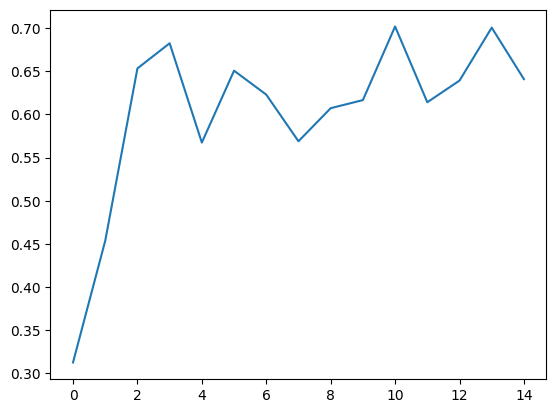

In [141]:
plt.plot(range(n), r2);